# Import necessary libraries

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPooling2D, BatchNormalization
from keras.datasets import cifar100
from keras.utils import to_categorical
from matplotlib import pyplot as plt

import numpy as np

from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import datetime, os

# Load training data

In [2]:
batch_size = 128
num_classes = 100

# Load data and view the shapes
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

print("x_train original shape", x_train.shape)
print("y_train original shape", y_train.shape)

x_train original shape (50000, 32, 32, 3)
y_train original shape (50000, 1)


In [3]:
img_width, img_height, img_num_channels = x_train.shape[1:4]
input_shape = (img_width, img_height, img_num_channels)
print(input_shape)

(32, 32, 3)


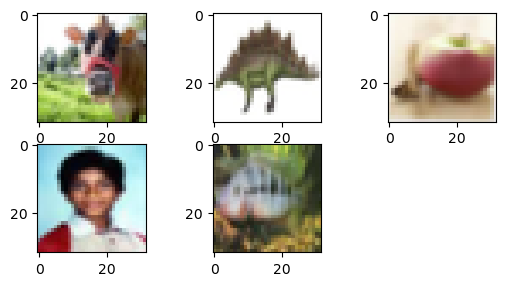

In [4]:
# Visualize the first 5 elements in our data

for i in range(5):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[i], cmap='gray', interpolation='none')

# Format the data for training


- Converting to float32 and performing normalization ensures our data is in the correct format for our neural network.



In [5]:
# 1. Conversion of the dataset to float 32 
# Save a copy of the original for later usage
x_train_display = x_train
x_test_display = x_test
# Conversion
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# 2. Normalization
# This function normalize inputs for zero mean and unit variance
# It is used when training a model.
# Input: training set and test set
# Output: normalized training set and test set according to the training set statistics.

# Calculate mean and standard deviation
mean = np.mean(x_train, axis=(0, 1, 2, 3))
std = np.std(x_train, axis=(0, 1, 2, 3))
print('np mean:', mean)
print('np std: ', std)

# Normalize the data
x_train = (x_train - mean) / (std + 1e-7)
x_test = (x_test - mean) / (std + 1e-7)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

np mean: 121.93584
np std:  68.38902
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


One-Hot format: Represent categorical variables as binary vectors. It is used for the multi-class classification problems.

* "cat" -> [1, 0, 0]
* "dog" -> [0, 1, 0]
* "bird" -> [0, 0, 1]

In [6]:
# Modify the label vectors to be in the one-hot format
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(y_train)
print(y_test)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Build a sequential convolutional model

In [7]:
from keras import regularizers

model = Sequential()
weight_decay = 0.0005

# first block
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# second block
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# third block
model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# flatten to 1D vector
model.add(Flatten())
model.add(BatchNormalization())

# output layer
model.add(Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(weight_decay)))  # 100 classes in CIFAR-100

In [8]:
# Load our previous training model
from keras.models import load_model

# Load the saved model and weights
model = load_model('best_conv.h5')
model.load_weights('my_model_weights.h5')

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 15, 15, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0

## Freezing Layers
* You can take advantage of transfer learning by freezing your trained model and training it again

In [9]:
# Freeze layers up to a certain point
for layer in model.layers[:2]:
    layer.trainable = False

In [10]:
# !pip install git+https://github.com/paulgavrikov/visualkeras --upgrade

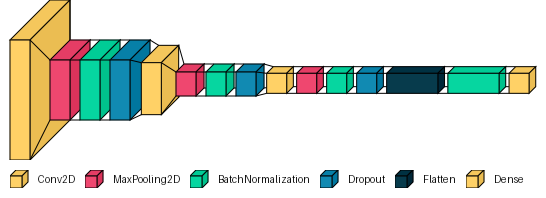

In [10]:
import visualkeras
visualkeras.layered_view(model, legend=True)

# Compile the model
- Choose your loss, optimizers, and any other metrics (e.g. Training accuracy, Test accuracy)

In [11]:
from keras import optimizers

# Training parameters
batch_size = 128
max_epoches = 50
learning_rate = 0.1
lr_decay = 1e-6
lr_drop = 20

# Optimization details
sgd = optimizers.SGD(learning_rate=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# Augmentation & Callbacks
* Callbacks for learning rate, saving model weights, and history saving
* Data augmentation for each image

In [12]:
from keras.callbacks import TensorBoard

In [13]:
# Load the TensorBoard notebook extension, do not have to touch this.
%load_ext tensorboard

##### reduce_lr
* This callback is responsible for adjusting the learning rate during training.

In [14]:
def lr_schedule(epoch):
    initial_lr = 0.05
    drop_factor = 0.5
    return initial_lr * (drop_factor ** (epoch // lr_drop))

reduce_lr = keras.callbacks.LearningRateScheduler(lr_schedule)

##### Early Stopping
* With more epochs, we can decrease our loss over time. This may lead to overfitting.
* Early stopping allows us to stop training when there is an increase in the loss value compared to the previous epoch.
* Detailed Arguments: https://keras.io/api/callbacks/early_stopping/

In [15]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8, restore_best_weights = True)

In [16]:
# For the TensorBoard, set the directory you want to save your log.
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S")) # log directory will be created
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [17]:
callbacks = [reduce_lr, early_stop, tensorboard_callback]
print(callbacks)

[<keras.callbacks.LearningRateScheduler object at 0x00000242892C4130>, <keras.callbacks.EarlyStopping object at 0x000002428ADBA880>, <keras.callbacks.TensorBoard object at 0x000002428ADBB100>]


##### Data Augmentation

In [18]:
from keras_preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center = False,  # set input mean to 0 over the dataset
    samplewise_center = False,  # set each sample mean to 0
    featurewise_std_normalization = False,  # divide inputs by std of the dataset
    samplewise_std_normalization = False,  # divide each input by its std
    zca_whitening = False,  # apply ZCA whitening
    rotation_range = 15,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range = 0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range = 0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip = True,  # randomly flip images
    vertical_flip = False)  # randomly flip images
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

# Training the Model

In [19]:
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=max_epoches,
    validation_data=(x_test, y_test),
    callbacks=callbacks,
    verbose=2
)

# history = model.fit(
#     x_train, y_train,
#     batch_size=batch_size,
#     epochs=100,
#     verbose=1,
#     callbacks=[early_stop,tensorboard_callback],
#     validation_data=(x_test, y_test)
# )

Epoch 1/50
390/390 - 29s - loss: 2.0981 - accuracy: 0.4453 - val_loss: 1.8996 - val_accuracy: 0.5023 - lr: 0.0500 - 29s/epoch - 75ms/step
Epoch 2/50
390/390 - 29s - loss: 2.0889 - accuracy: 0.4499 - val_loss: 1.9002 - val_accuracy: 0.4994 - lr: 0.0500 - 29s/epoch - 75ms/step
Epoch 3/50
390/390 - 29s - loss: 2.0965 - accuracy: 0.4467 - val_loss: 1.9036 - val_accuracy: 0.5000 - lr: 0.0500 - 29s/epoch - 73ms/step
Epoch 4/50
390/390 - 28s - loss: 2.0997 - accuracy: 0.4458 - val_loss: 1.8984 - val_accuracy: 0.5018 - lr: 0.0500 - 28s/epoch - 71ms/step
Epoch 5/50
390/390 - 27s - loss: 2.0993 - accuracy: 0.4455 - val_loss: 1.9061 - val_accuracy: 0.5010 - lr: 0.0500 - 27s/epoch - 70ms/step
Epoch 6/50
390/390 - 27s - loss: 2.0960 - accuracy: 0.4452 - val_loss: 1.8956 - val_accuracy: 0.4992 - lr: 0.0500 - 27s/epoch - 69ms/step
Epoch 7/50
390/390 - 27s - loss: 2.0999 - accuracy: 0.4457 - val_loss: 1.8974 - val_accuracy: 0.5010 - lr: 0.0500 - 27s/epoch - 69ms/step
Epoch 8/50
390/390 - 28s - loss: 2

#### Saving the Training

In [20]:
# save the model
model.save("best_conv.h5")
print("Model saved successfully")

# Save model weights to HDF5 file
model.save_weights('my_model_weights.h5')
print("Model weights saved successfully")

# Save the history object using pickle:
import pickle
with open('history.pkl', 'wb') as file:
    pickle.dump(history.history, file)
print("History saved successfully")

Model saved successfully
Model weights saved successfully
History saved successfully


Basics of Tensorboard, you can change options to change the shapes of scalars.

https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/tensorboard_in_notebooks.ipynb

In [21]:
%tensorboard --logdir logs

# Evaluate its performance

In [22]:
# Calculate model score
score = model.evaluate(x_test, y_test, batch_size=50, steps=x_test.shape[0] // 50)

# Print test loss and accuracy
print('Test loss: %.2f' % score[0])
print('Test accuracy: %.2f' % score[1])

200/200 [==============================] - 1s 5ms/step - loss: 1.8956 - accuracy: 0.4992
Test loss: 1.90
Test accuracy: 0.50


##### Confusion Matrix
A confusion matrix is a visual representation used to evaluate the performance of a binary classification model. It provides a summary of the predictions made by the model compared to the actual class labels. The confusion matrix is a 2x2 table that shows the number of true positives (TP), false positives (FP), true negatives (TN), and false negatives (FN) for each class.
* True Positives (TP): The number of instances where the model correctly predicted a positive class and the actual class is also positive.
* False Positives (FP): The number of instances where the model incorrectly predicted a positive class when the actual class is negative.
* True Negatives (TN): The number of instances where the model correctly predicted a negative class and the actual class is also negative.
* False Negatives (FN): The number of instances where the model incorrectly predicted a negative class when the actual class is positive.

In [23]:
from sklearn.metrics import confusion_matrix

# Calculate predicted labels for the test set
predicted_labels = model.predict(x_test)
predicted_labels = np.argmax(predicted_labels, axis=1)

# Calculate confusion matrix
confusion_matrix_values = confusion_matrix(y_test.argmax(axis=1), predicted_labels)

# Print the confusion matrix as a table
print("\nConfusion Matrix:")
print("   | PP | PN")
print("AP |", confusion_matrix_values[0, 0], "|", confusion_matrix_values[0, 1])
print("AN |", confusion_matrix_values[1, 0], " |", confusion_matrix_values[1, 1])

313/313 [==============================] - 1s 3ms/step

Confusion Matrix:
   | PP | PN
AP | 69 | 2
AN | 0  | 69


## Results

Using matplotlib to draw results.

Test loss: 1.8955775499343872 / Test accuracy: 0.4991999864578247


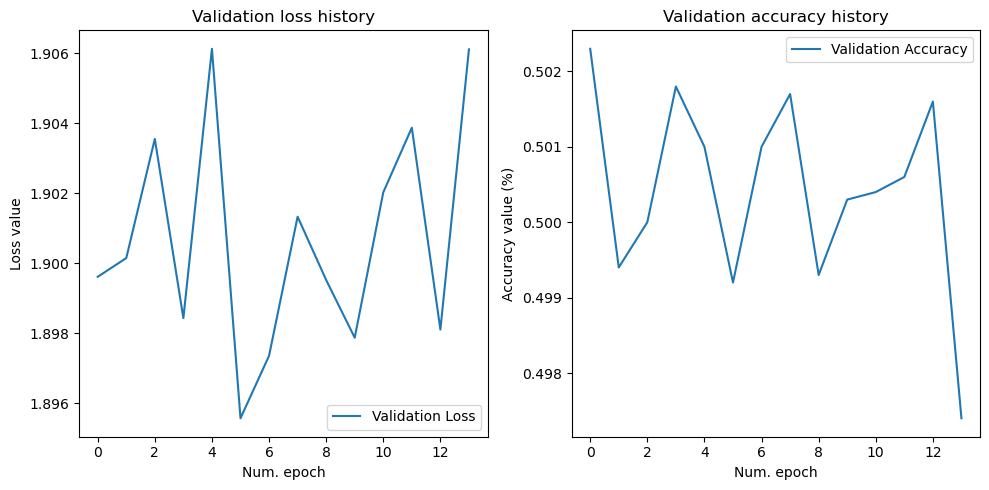

In [24]:
import matplotlib.pyplot as plt

score = model.evaluate(x_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

plt.figure(figsize=(10, 5))

# here we plot our validation curves as an example.

# Plot validation loss history
plt.subplot(1, 2, 1)
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Validation loss history')
plt.ylabel('Loss value')
plt.xlabel('Num. epoch')
plt.legend()

# Plot validation accuracy history
plt.subplot(1, 2, 2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Validation accuracy history')
plt.ylabel('Accuracy value (%)')
plt.xlabel('Num. epoch')
plt.legend()

plt.tight_layout()
plt.show()

##### Label Names

In [25]:
class_names = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard',
    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
    'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
    'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea',
    'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower',
    'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle',
    'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

In [26]:
import random

# Predict classes
predictions = model.predict(x_test)

# Choose 10 random indices
random_indices = random.sample(range(len(x_test)), 10)

# Make predictions on the selected random test data
selected_x_test = x_test[random_indices]
selected_y_test = y_test[random_indices]
selected_predictions = model.predict(selected_x_test)

1/1 [==============================] - 0s 26ms/step


##### Original Photos

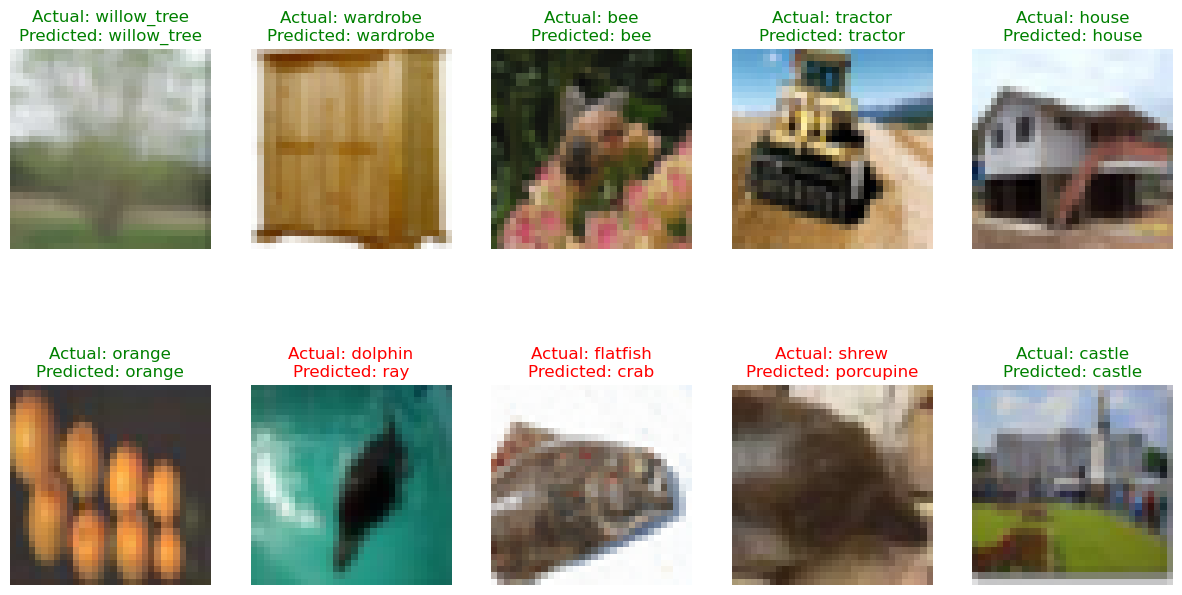

In [27]:
# Display the randomly selected test images along with their predicted and actual classes

plt.figure(figsize=(15, 8))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test_display[idx])

    actual_class = int(np.argmax(selected_y_test[i]))  # Assuming y_test is one-hot encoded
    predicted_class = int(np.argmax(selected_predictions[i]))

    # Check if the prediction is correct
    text_color = 'green' if actual_class == predicted_class else 'red'

    plt.title(f'Actual: {class_names[actual_class]}\nPredicted: {class_names[predicted_class]}', color=text_color)
    plt.axis('off')

plt.show()

##### Normalized Photos

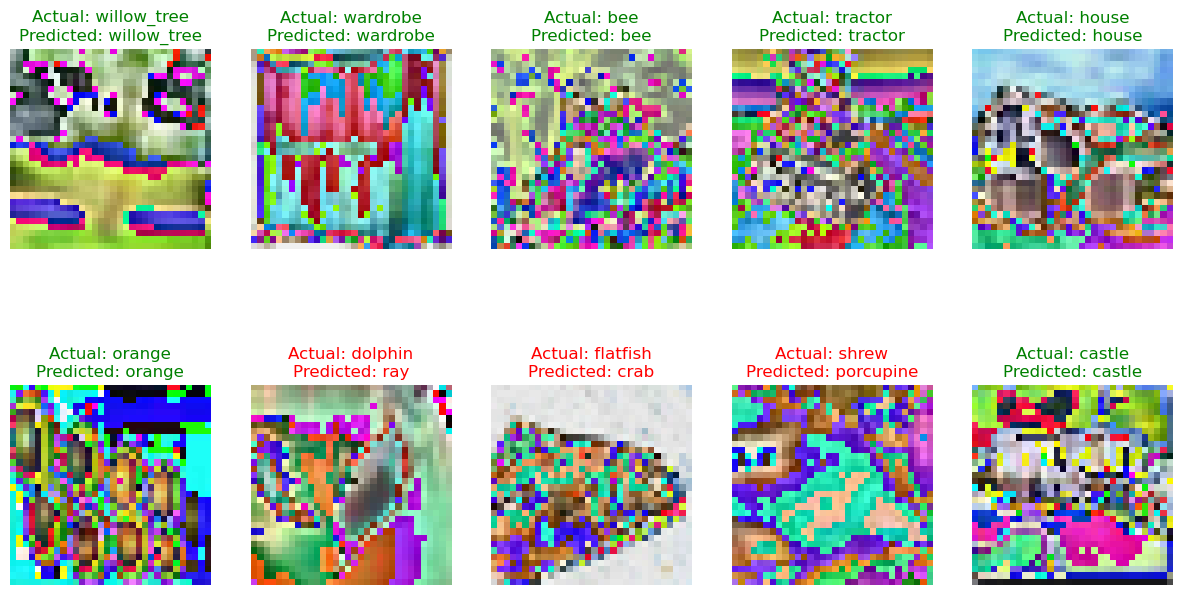

In [28]:
# Display the randomly selected test images along with their predicted and actual classes

plt.figure(figsize=(15, 8))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(((x_test * 255).astype(np.uint8))[idx]) # Fit inside RGB range

    actual_class = int(np.argmax(selected_y_test[i]))  # Assuming y_test is one-hot encoded
    predicted_class = int(np.argmax(selected_predictions[i]))

    # Check if the prediction is correct
    text_color = 'green' if actual_class == predicted_class else 'red'

    plt.title(f'Actual: {class_names[actual_class]}\nPredicted: {class_names[predicted_class]}', color=text_color)
    plt.axis('off')

plt.show()